<a href="https://colab.research.google.com/github/PosgradoMNA/actividades-de-aprendizaje-FranciscoMedellin/blob/main/Actividad_Semanal_7_kmeans_target.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Este notebook se basa en información de target
![imagen.png](https://www.america-retail.com/static//2020/12/target01.jpg)


Ahora imagina que somos parte del equipo de data science de la empresa Target, una de las tiendas con mayor presencia en Estados Unidos. El departamento de logistica acude a nosotros para saber donde le conviene poner sus almacenes, para que se optimice el gasto de gasolina, los tiempos de entrega de los productos y se disminuyan costos. Para ello, nos pasan los datos de latitud y longitud de cada una de las tiendas.

https://www.kaggle.com/datasets/saejinmahlauheinert/target-store-locations?select=target-locations.csv

Si quieres saber un poco más de graficas geográficas consulta el siguiente notebook
https://colab.research.google.com/github/QuantEcon/quantecon-notebooks-datascience/blob/master/applications/maps.ipynb#scrollTo=uo2oPtSCeAOz

In [1]:
! pip install qeds fiona geopandas xgboost gensim folium pyLDAvis descartes

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 16.7 MB 679 kB/s 
     |████████████████████████████████| 1.0 MB 15.4 MB/s 
     |████████████████████████████████| 1.7 MB 43.7 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 179 kB 31.2 MB/s 
     |████████████████████████████████| 6.3 MB 49.2 MB/s 
  Created wheel for qeds: filename=qeds-0.7.0-py3-none-any.whl size=27812 sha256=2b6f1c50c4ee5af7bd1dd4980137abb546efbc9306618202f1ee3c2103a7ab34
  Stored in directory: /root/.cache/pip/wheels/fc/8c/52/0cc036b9730b75850b9845770780f8d05ed08ff38a67cbaa29
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136897 sha256=e1af4706672c0ecce13337b556f24baaf4b1a81afab523b01d07bd3c418121bc
  Stored in directory: /root/.

In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import geopandas

Importa la base de datos

In [3]:
url="https://raw.githubusercontent.com/marypazrf/bdd/main/target-locations.csv"
df=pd.read_csv(url)

Exploremos los datos.

In [4]:

df.head()


,name,latitude,longitude,address,phone,website
0,Alabaster,33.224225,-86.804174,"250 S Colonial Dr, Alabaster, AL 35007-4657",205-564-2608,https://www.target.com/sl/alabaster/2276
1,Bessemer,33.334550,-86.989778,"4889 Promenade Pkwy, Bessemer, AL 35022-7305",205-565-3760,https://www.target.com/sl/bessemer/2375
2,Daphne,30.602875,-87.895932,"1698 US Highway 98, Daphne, AL 36526-4252",251-621-3540,https://www.target.com/sl/daphne/1274
3,Decatur,34.560148,-86.971559,"1235 Point Mallard Pkwy SE, Decatur, AL 35601-...",256-898-3036,https://www.target.com/sl/decatur/2084
4,Dothan,31.266061,-85.446422,"4601 Montgomery Hwy, Dothan, AL 36303-1522",334-340-1112,https://www.target.com/sl/dothan/1468


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1839 entries, 0 to 1838
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   name       1839 non-null   object 
 1   latitude   1839 non-null   float64
 2   longitude  1839 non-null   float64
 3   address    1839 non-null   object 
 4   phone      1839 non-null   object 
 5   website    1839 non-null   object 
dtypes: float64(2), object(4)
memory usage: 86.3+ KB


**Definición de Latitud y Longitud**

**Latitud** Es la distancia en grados, minutos y segundos que hay con respecto al paralelo principal, que es el ecuador (0º). La latitud puede ser norte y sur.

**Longitud**: Es la distancia en grados, minutos y segundos que hay con respecto al meridiano principal, que es el meridiano de Greenwich (0º).La longitud puede ser este y oeste.

In [27]:
latlong=df[["latitude","longitude"]]

¡Visualizemos los datos!, para empezar a notar algún patron. 

A simple vista pudieramos pensar que tenemos algunos datos atípicos u outliers, pero .... no es así, simplemente esta grafica no nos está dando toda la información.

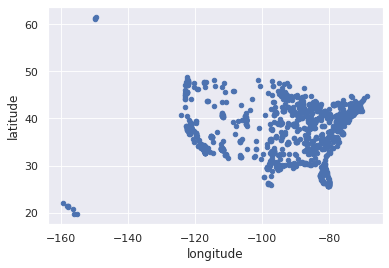

In [26]:
#extrae los datos interesantes
latlong.plot.scatter( "longitude","latitude")

In [8]:
latlong.describe()

,latitude,longitude
count,1839.000000,1839.000000
mean,37.791238,-91.986881
std,5.272299,16.108046
min,19.647855,-159.376962
25%,33.882605,-98.268828
50%,38.955432,-87.746346
75%,41.658341,-80.084833
max,61.577919,-68.742331


Para entender un poco más, nos auxiliaremos de una librería para graficar datos geográficos. Esto nos ayudara a tener un mejor entendimiento de ellos.




In [9]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

from shapely.geometry import Point

%matplotlib inline
# activate plot theme
import qeds
qeds.themes.mpl_style();

In [118]:
df["Coordinates"] = list(zip(df.longitude, df.latitude))
df["Coordinates"] = df["Coordinates"].apply(Point)
df.head()

,name,latitude,longitude,address,phone,website,Coordinates
0,Alabaster,33.224225,-86.804174,"250 S Colonial Dr, Alabaster, AL 35007-4657",205-564-2608,https://www.target.com/sl/alabaster/2276,POINT (-86.80417369999999 33.2242254)
1,Bessemer,33.334550,-86.989778,"4889 Promenade Pkwy, Bessemer, AL 35022-7305",205-565-3760,https://www.target.com/sl/bessemer/2375,POINT (-86.98977789999999 33.3345501)
2,Daphne,30.602875,-87.895932,"1698 US Highway 98, Daphne, AL 36526-4252",251-621-3540,https://www.target.com/sl/daphne/1274,POINT (-87.89593169999999 30.6028747)
3,Decatur,34.560148,-86.971559,"1235 Point Mallard Pkwy SE, Decatur, AL 35601-...",256-898-3036,https://www.target.com/sl/decatur/2084,POINT (-86.9715595 34.5601477)
4,Dothan,31.266061,-85.446422,"4601 Montgomery Hwy, Dothan, AL 36303-1522",334-340-1112,https://www.target.com/sl/dothan/1468,POINT (-85.4464222 31.2660613)


In [12]:
gdf = gpd.GeoDataFrame(df, geometry="Coordinates")
gdf.head()

,name,latitude,longitude,address,phone,website,Coordinates
0,Alabaster,33.224225,-86.804174,"250 S Colonial Dr, Alabaster, AL 35007-4657",205-564-2608,https://www.target.com/sl/alabaster/2276,POINT (-86.80417 33.22423)
1,Bessemer,33.334550,-86.989778,"4889 Promenade Pkwy, Bessemer, AL 35022-7305",205-565-3760,https://www.target.com/sl/bessemer/2375,POINT (-86.98978 33.33455)
2,Daphne,30.602875,-87.895932,"1698 US Highway 98, Daphne, AL 36526-4252",251-621-3540,https://www.target.com/sl/daphne/1274,POINT (-87.89593 30.60287)
3,Decatur,34.560148,-86.971559,"1235 Point Mallard Pkwy SE, Decatur, AL 35601-...",256-898-3036,https://www.target.com/sl/decatur/2084,POINT (-86.97156 34.56015)
4,Dothan,31.266061,-85.446422,"4601 Montgomery Hwy, Dothan, AL 36303-1522",334-340-1112,https://www.target.com/sl/dothan/1468,POINT (-85.44642 31.26606)


In [13]:
#mapa

world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
world = world.set_index("iso_a3")

world.head()

,pop_est,continent,name,gdp_md_est,geometry
iso_a3,,,,,
FJI,920938,Oceania,Fiji,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
TZA,53950935,Africa,Tanzania,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
ESH,603253,Africa,W. Sahara,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
CAN,35623680,North America,Canada,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
USA,326625791,North America,United States of America,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


In [14]:
#graficar el mapa
world.name.unique()

array(['Fiji', 'Tanzania', 'W. Sahara', 'Canada',
       'United States of America', 'Kazakhstan', 'Uzbekistan',
       'Papua New Guinea', 'Indonesia', 'Argentina', 'Chile',
       'Dem. Rep. Congo', 'Somalia', 'Kenya', 'Sudan', 'Chad', 'Haiti',
       'Dominican Rep.', 'Russia', 'Bahamas', 'Falkland Is.', 'Norway',
       'Greenland', 'Fr. S. Antarctic Lands', 'Timor-Leste',
       'South Africa', 'Lesotho', 'Mexico', 'Uruguay', 'Brazil',
       'Bolivia', 'Peru', 'Colombia', 'Panama', 'Costa Rica', 'Nicaragua',
       'Honduras', 'El Salvador', 'Guatemala', 'Belize', 'Venezuela',
       'Guyana', 'Suriname', 'France', 'Ecuador', 'Puerto Rico',
       'Jamaica', 'Cuba', 'Zimbabwe', 'Botswana', 'Namibia', 'Senegal',
       'Mali', 'Mauritania', 'Benin', 'Niger', 'Nigeria', 'Cameroon',
       'Togo', 'Ghana', "Côte d'Ivoire", 'Guinea', 'Guinea-Bissau',
       'Liberia', 'Sierra Leone', 'Burkina Faso', 'Central African Rep.',
       'Congo', 'Gabon', 'Eq. Guinea', 'Zambia', 'Malawi', 'M

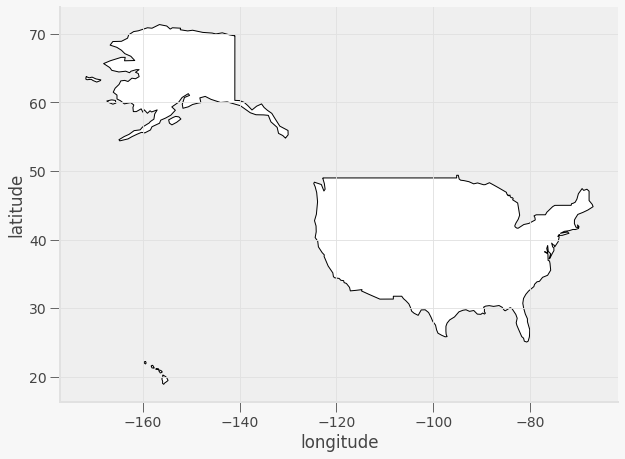

In [15]:
fig, gax = plt.subplots(figsize=(10,10))

# By only plotting rows in which the continent is 'South America' we only plot SA.
world.query("name == 'United States of America'").plot(ax=gax, edgecolor='black',color='white')

# By the way, if you haven't read the book 'longitude' by Dava Sobel, you should...
gax.set_xlabel('longitude')
gax.set_ylabel('latitude')

gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)

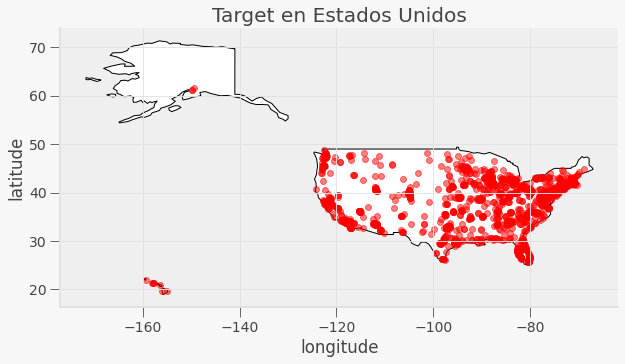

In [16]:
# Step 3: Plot the cities onto the map
# We mostly use the code from before --- we still want the country borders plotted --- and we
# add a command to plot the cities
fig, gax = plt.subplots(figsize=(10,10))

# By only plotting rows in which the continent is 'South America' we only plot, well,
# South America.
world.query("name == 'United States of America'").plot(ax = gax, edgecolor='black', color='white')

# This plot the cities. It's the same syntax, but we are plotting from a different GeoDataFrame.
# I want the cities as pale red dots.
gdf.plot(ax=gax, color='red', alpha = 0.5)

gax.set_xlabel('longitude')
gax.set_ylabel('latitude')
gax.set_title('Target en Estados Unidos')

gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)

plt.show()

¿qué tal ahora?, tiene mayor sentido verdad, entonces los datos lejanos no eran atípicos, de aquí la importancia de ver los datos con el tipo de gráfica correcta.

Ahora sí, implementa K means a los datos de latitud y longitud :) y encuentra donde colocar los almacenes. 

Nota: si te llama la atención implementar alguna otra visualización con otra librería, lo puedes hacer, no hay restricciones.

<h2>Ahora imagina que somos parte del equipo de data science de la empresa Target, una de las tiendas con mayor presencia en Estados Unidos. El departamento de logistica acude a nosotros para saber dónde le conviene poner sus almacenes, para que se optimice el gasto de gasolina, los tiempos de entrega de los productos y se disminuyan costos. Para ello, nos pasan los datos de latitud y longitud de cada una de las tiendas.<h2>

## Implementa K means

Importamos las librerias necesarias para K-Means

In [82]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling
import numpy as np

Seleccionamos los datos de latitud y longitud

In [19]:
X = df[["latitude","longitude"]]
X.head()

,latitude,longitude
0,33.224225,-86.804174
1,33.334550,-86.989778
2,30.602875,-87.895932
3,34.560148,-86.971559
4,31.266061,-85.446422


Visualizemos un modelo k-means con un valore aleatorio de n_clusters.

In [50]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4)
kmeans.fit(latlong)
y_kmeans = kmeans.predict(latlong)

Visualizamos los resultados coloreando los diferentes clusters y sus respectivos centros.

Imprimimos los centros de los clusters: 
 [[  36.99505521  -96.97278809]
 [  36.55629613  -84.80260815]
 [  37.57757741 -119.14645561]
 [  40.34198355  -75.26720102]]


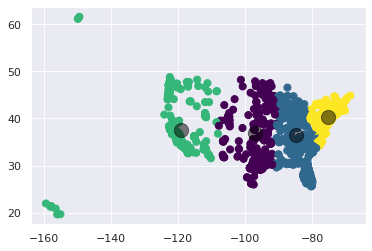

In [46]:
plt.scatter(latlong["longitude"], latlong["latitude"], c = y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
print("Imprimimos los centros de los clusters: \n",centers)
plt.scatter(centers[:, 1], centers[:, 0], c='black', s=200, alpha=0.5)

# ¿Cómo elegimos el número de almacenes?

El metodo de optimizacion que se usara es silhouette analysis, el cual mediante el silhouette score nos da una idea del numero optimo de clusters que necesitamos.<br>

Cuando el coeficiente silhouette se acerce a +1 significara que la instancia de los puntos esta bien dentro del cluster al que ya pertenece, mientras que un coeficiente cercano a 0 significara que la instancia del punto esta cerca del perimetro del cluster. Finalmente un coeficiente cercano a -1 significa que la instancia de un punto tal ves ha sido asignada al cluster equivocado.

Genaramos n modelos al azar para poder obtener multiples silhouette scores y seleccionar el mejor.

In [100]:
kmeans_per_k = [ KMeans(n_clusters=k, random_state=42).fit(latlong) for k in range(1, 11) ]

Busquemos el silhouette score el cual es la media del coeficiente silhouette de cada instancia (punto o valor de datos).

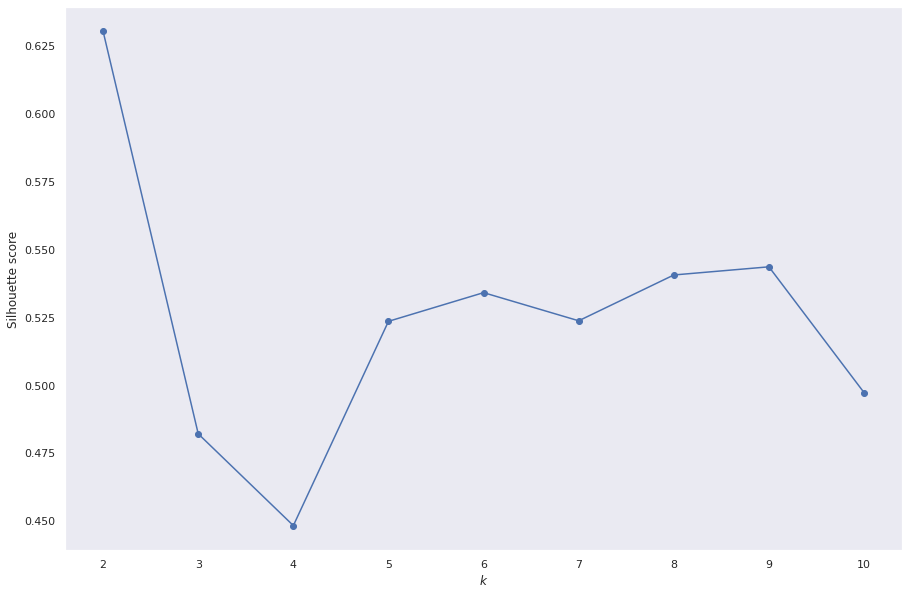

In [101]:
from sklearn.metrics import silhouette_score

silhouette_scores = [silhouette_score(latlong, model.labels_)
                     for model in kmeans_per_k[1:]]

plt.figure(figsize=(15, 10))
plt.plot(range(2, 11), silhouette_scores, "bo-")
plt.xlabel("$k$")
plt.ylabel("Silhouette score")
plt.grid()
plt.show()

Mediante silhouette podemos ver que el mejor score es el de k=2 y que k=5 es el proximo a tener un buen score.

Con esto podemos deducit que 2 o 5 almacenes para el pais de Estados Unidos serian una buena opcion.

Por cuestiones de tiempos para entregas y costos de envio mas accesibles 5 para ser la mejor opcion.

## Justificacion Tecnica de la respuesta

Comprobemos mediante el metodo del codo y el diagrama silhouette.

**Metodo del Codo**

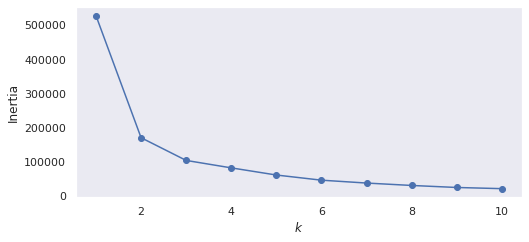

In [102]:
inertias = [model.inertia_ for model in kmeans_per_k]

plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 11), inertias, "bo-")
plt.xlabel("$k$")
plt.ylabel("Inertia")
# plt.annotate("", xy=(4, inertias[3]), xytext=(4.45, 650),
#              arrowprops=dict(facecolor='black', shrink=0.1))
# plt.text(4.5, 650, "Elbow", horizontalalignment="center")
# plt.axis([1, 8.5, 0, 1300])
plt.grid()
plt.show()

Vemos que los codos mas visibles codos de la curva  estan en K=2 y en k=5.

Ahora necesitamos conocer cual de ellos es la mejor opcion

**Diagrama silhouette**

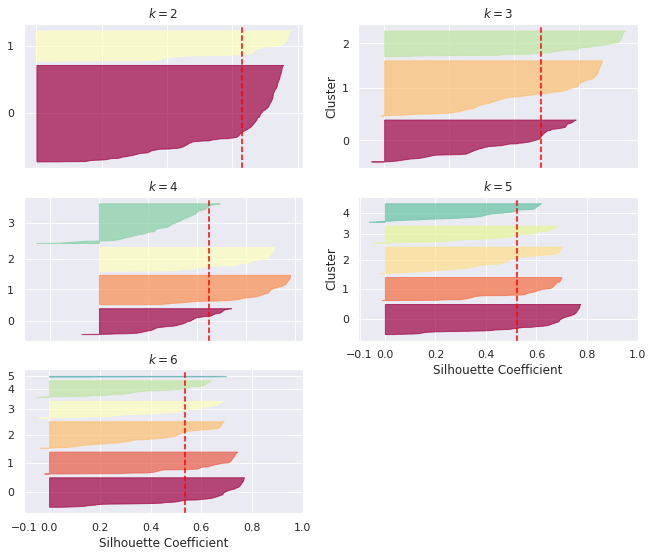

In [108]:
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter

plt.figure(figsize=(11, 9))

for k in (2, 3, 4, 5, 6):
    plt.subplot(3, 2, k - 1)
    
    y_pred = kmeans_per_k[k - 1].labels_
    silhouette_coefficients = silhouette_samples(latlong, y_pred)

    padding = len(latlong) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = plt.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 5):
        plt.ylabel("Cluster")
    
    if k in (5, 6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title(f"$k={k}$")

plt.show()

- Conociendo que los posibles codos son k=2 y k=5.

- Con k=2 podemos ver buena distribucion pero tal vez existan mejores opciones que tengan una mayor cantidad de clusters.

- Con k=5 ahora podemos ver es el mejor, ya que sus clusters son casi del mismo tamaño y todos cruzan la linea roja que representa el silhouette score.

- Respuesta final: 5 Almacenes en estados unidos son la mejor opcion

# Latitudes y longitudes de los almacenes,

Las latitudes y longitudes de nuestros almacenes son: 
 [[  37.57977424 -119.17634307]
 [  34.40676796  -98.24207528]
 [  40.34589747  -75.59822436]
 [  31.0894544   -82.8883261 ]
 [  41.74621079  -88.36689969]]


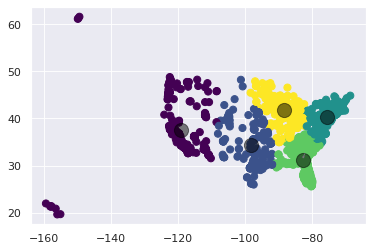

In [115]:
# Entrenemos nuestro modelo con n_clusters = 5
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5)
kmeans.fit(latlong)
y_kmeans = kmeans.predict(latlong)

# Grafica para anlisis visual de nuestros clusters y locacion de los almacenes
plt.scatter(latlong["longitude"], latlong["latitude"], c = y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
print("Las latitudes y longitudes de nuestros almacenes son: \n",centers)
plt.scatter(centers[:, 1], centers[:, 0], c='black', s=200, alpha=0.5)

**Las latitudes y longitudes de nuestros almacenes son:** 
- [  37.57977424 -119.17634307]
- [  34.40676796  -98.24207528]
- [  40.34589747  -75.59822436]
- [  31.0894544   -82.8883261 ]
- [  41.74621079  -88.36689969]

##  ¿Qué ciudad es?, ¿a cuantas tiendas va surtir?, ¿sabes a que distancia estará?




### Datos Almacen 1

**Ubicacion del almacen 1**

In [183]:
# Usamos los centros y asignamos un rango dentro del cual podrian estar ciudades.
# Utilizamos df que contiene datos de las ciudades y sus coordenadas.
# Jugamos con los filtros
temp = df[(df['latitude']>=(kmeans.cluster_centers_[0][0])) & 
   (df['latitude']<(kmeans.cluster_centers_[0][0]+0.5)) & 
   (df['longitude']<=(kmeans.cluster_centers_[0][1])) & 
   (df['longitude']>(kmeans.cluster_centers_[0][1]-1.8))
]
city =  np.array(temp["name"])[0]

**A que distancia esta del centro del cluster?**

In [209]:
from numpy.ma.core import sqrt
import numpy as np
from math import sqrt
# arrays de coordeanadas
p_city = df[df["name"]==city]
p_city = (np.array(p_city[["latitude","longitude"]]))
p_center = (centers[0])


# dist = sqrt(  (p_city[0][0]-p_center[0][0])*(p_city[0][0]-p_center[0][0])  )#+  (p_city[1]-p_center[1])*(p_city[1]-p_center[1])  )
# dist
dist = np.linalg.norm(p_city-p_center)
print("Distancia: ",dist)

Distancia:  1.7813797007089092


In [ ]:
Ñ